## Comparison between precipitation features and convective cells based on CTT 

**Notes:** 
    

*Method section*

- lifetime: tb cold, smallscale
- seasonal curve: all, TP, outside of TP
- area: tb cold, small scale 
- total nr of tracks 


*Spatial and Temporal characteristics*

- distribution for propagation speed, lifetime, area and seasonal curve for classes
- density plots for four classes 



*Precipitation*

- plot with contribution of total precip > 3000m, from heavy precip > 5mm which are non contiguous/isolated (local precip), contiguous in space (at least 10 pixels), contiguous in space and time (10 pixels and 3 hours), incorporated in precipitating cloud system (combined tracking) 




**TODO**

- wait for finished ptracking and tracking 
- include smallscale tracking 
- TP mask 
- function for density plots 
- function for precipitation feature analysis 


## get tracks for one year 

In [5]:
import pandas as pd
import numpy as np
import tobac 
import cartopy
import cartopy.crs as ccrs

In [251]:
# read in precip tracks 
y= 2000


precipfile = '/media/juli/Elements/gpm_v06/Save/2000_2019/Tracks_precipitation_GPM_'+ str(y) + '.h5'
ptracks= pd.read_hdf(precipfile, 'table')
preciptracks = ptracks[ptracks.cell >= 0]
preciptracks.timestr = pd.to_datetime(preciptracks.timestr)


# read in CTT tracks heavy rain core 
tp = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/smallscale/Tracks_'+str(y)+'_heavyraincorefiltered.h5'
tptracks= pd.read_hdf(tp, 'table')
tptracks.timestr = pd.to_datetime(tptracks.timestr)



# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_'+str(y)+'_heavyraincorefiltered.h5'
tbbtracks= pd.read_hdf(tbb, 'table')
tbbtracks.timestr = pd.to_datetime(tbbtracks.timestr)
tbbtracks= tobac.calculate_velocity(tbbtracks, method_distance=None)


# read in CTT tracks cold core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_'+ str(y)+'_cold_core.h5'
tbbcold= pd.read_hdf(tbb, 'table')
tbbcold.timestr = pd.to_datetime(tbbcold.timestr)


# read in CTT tracks only tbb 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks__'+ str(y)+'.h5'
tbb= pd.read_hdf(tbb, 'table')
tbb.timestr = pd.to_datetime(tbb.timestr)

## get tracks for all years : 2000 - 2019 

In [703]:
# read in cells from precip tracking 
years = np.arange(2001,2020)

for y in years:
    print(y)
    # read in precip tracks 
    f = '/media/juli/Elements/gpm_v06/Save/2000_2019/Tracks_precipitation_GPM_'+ str(y) + '.h5'
    ptracks= pd.read_hdf(f, 'table')
    # remove nan values to only save the linked features                                                                                                       
    ptracks = ptracks[ptracks.cell >= 0]
    ptracks.timestr = pd.to_datetime(ptracks.timestr)
    preciptracks = preciptracks.append(ptracks)
    
    
        
    # read in CTT tracks heavy rain core 
    f = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/smallscale/Tracks_'+str(y)+'_heavyraincorefiltered.h5'
    smallscale= pd.read_hdf(f, 'table')
    smallscale.timestr = pd.to_datetime(smallscale.timestr)
    tptracks = tptracks.append(smallscale)

    
     # read in CTT tracks heavy rain core 
    f = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_'+str(y)+'_heavyraincorefiltered.h5'
    tbhtracks= pd.read_hdf(f, 'table')
    tbhtracks.timestr = pd.to_datetime(tbhtracks.timestr)
    tbhtracks= tobac.calculate_velocity(tbhtracks, method_distance=None)
    tbbtracks = tbbtracks.append(tbhtracks)


    # read in CTT tracks cold core 
    f = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_'+ str(y)+'_cold_core.h5'
    tbccold= pd.read_hdf(f, 'table')
    tbccold.timestr = pd.to_datetime(tbccold.timestr)
    tbbcold = tbbcold.append(tbccold)


    # read in CTT tracks only tbb 
    f = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks__'+ str(y)+'.h5'
    tb= pd.read_hdf(f, 'table')
    tb.timestr = pd.to_datetime(tb.timestr)   
    tbb = tbb.append(tb)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


## get cells for one season

In [36]:
# get only summer cells 
tracks = preciptracks
for i in np.unique(tracks.time.values):
    if i.month not in [6,7, 8]:
        tracks.drop(tracks.loc[tracks['time']== i].index, inplace=True)

In [37]:
summertracks = tracks 
summertracks.to_hdf('/media/juli/Elements/gpm_v06/Save/Tracks_GPM_2000_2019_JJA.h5', 'table')
n= np.unique(summertracks.timestr).shape[0]
n / (48*90*20) * 100

40.58796296296296

## Diurnal cycle 

In [267]:
# function to get seasonal curve of tracks
def get_diurnal_cycle(preciptracks):
    preciptracks['hour']= preciptracks.timestr.dt.hour
    diurnal=[]
    for h in np.arange(0,23):
        count = preciptracks[preciptracks.hour == h].shape[0]
        #meanvalue= np.nanmean(preciptracks.total_precip.values)
        diurnal.append(count)
    return diurnal

In [314]:
# get dataframe with max values 

def get_max_values(tracks):
    tracks['hour']= tracks.timestr.dt.hour
    peak_frame = pd.DataFrame(columns = tracks.columns)
    rain_peak = []
    for cell in np.unique(tracks.cell.values):
        subset= tracks[tracks.cell == cell]
        peak = np.nanmax(subset.total_precip.values)
        hour = subset[subset.total_precip == peak].hour.values[0]
        # add row to dataframe 
        #peak_frame = pd.concat([peak_frame, rain_peak ], ignore_index=True)
        rain_peak.append(hour)
    rain_histo = np.histogram(rain_peak, bins = np.arange(0,24))
    return rain_histo[0]


In [331]:

diurnal_precip = get_max_values(tracks_N)
diurnal_tbb_rain= get_max_values(tracks_E)
diurnal_tbb_cold= get_max_values(tracks_n)
diurnal_tbb= get_max_values(tracks_e)


In [324]:
diurnal_precip = get_diurnal_cycle(tracks_N)
diurnal_tbb_rain= get_diurnal_cycle(tracks_E)
diurnal_tbb_cold= get_diurnal_cycle(tracks_n)
diurnal_tbb= get_diurnal_cycle(tracks_e)


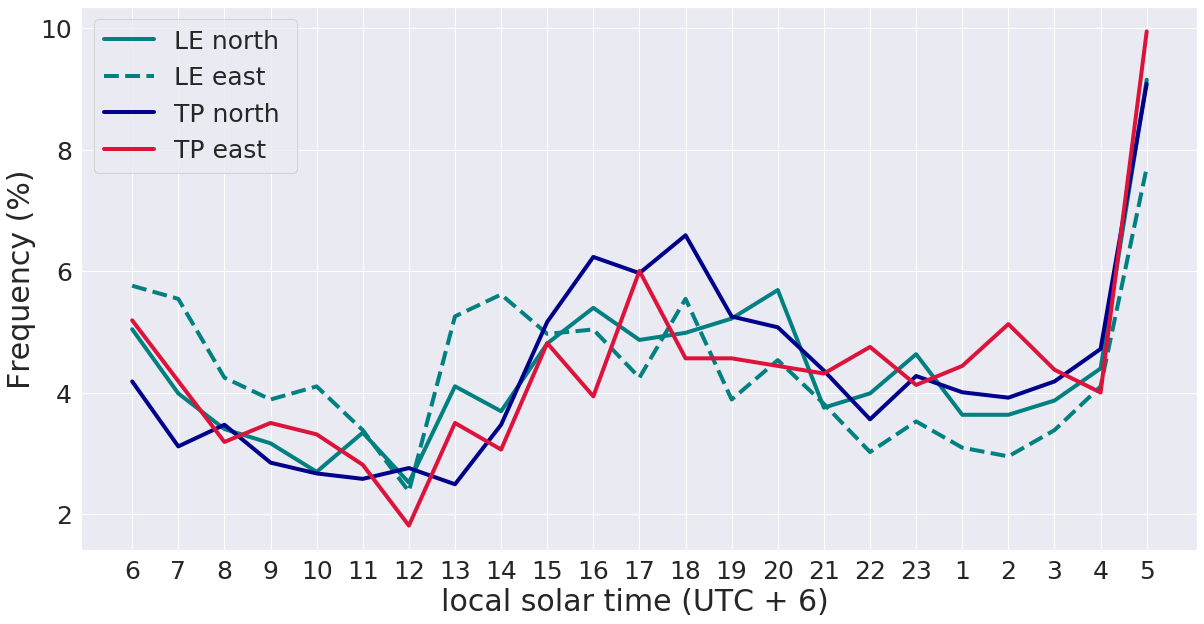

In [335]:

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()


a= np.arange(0,18) + 6 
b= np.arange(1,6)
localtime= np.append(a, b)


plt.figure(figsize=(20,10))


plt.plot(diurnal_precip/np.nansum(diurnal_precip)*100, label = 'LE north ', color= 'teal', linewidth = 4)
plt.plot(diurnal_tbb_rain/ np.nansum(diurnal_tbb_rain)*100, label = 'LE east ', color= 'teal',linestyle='--',  linewidth = 4)
plt.plot(diurnal_tbb_cold/ np.nansum(diurnal_tbb_cold)*100, label = 'TP north', color= 'darkblue', linewidth = 4)
plt.plot(diurnal_tbb/ np.nansum(diurnal_tbb)*100, label = 'TP east', color= 'crimson', linewidth = 4)

#plt.plot(max_precip/np.nansum(max_precip), label = 'max precip', color= 'darkred')

plt.legend(fontsize= 25)

plt.xticks(np.arange(0,23), labels= localtime.astype(str), fontsize= 25)
plt.yticks(np.linspace(2,10,5), fontsize= 25)

plt.xlabel('local solar time (UTC + 6) ', fontsize = 30 )
plt.ylabel('Frequency (%)', fontsize = 30 )
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/diurnal_cycle_maxrainfallhour.png')
plt.show()


## Get total track numbers : outside and over plateau 

maybe also divide between entirely or partly within 3000 m boundary 

In [704]:
def count_tracks(tracks):
    count = 0 
    for y in np.unique(tracks.timestr.dt.year):
        subset = tracks[tracks.timestr.dt.year == y]
        count += np.unique(subset.cell.values).shape[0]
    return count 

In [705]:
count = count_tracks(tptracks)
print('TP',count/20)

TP 11.1


In [469]:
count = count_tracks(tbbtracks)
print('tbb rain',count/20)
count = count_tracks(tbbcold)
print('tbb cold',count/20)
count = count_tracks(tbb)
print('tbb', count/20)
count = count_tracks(preciptracks)
print('P', count /20)

tbb rain 517.4
tbb cold 555.3
tbb 3680.45
P 9063.7


## divide dataset in plateau and outside of plateau cells 

In [710]:
def divide_data(tracks):
    tp_tracks= pd.DataFrame(columns = tracks.columns)
    surrounding_tracks= pd.DataFrame(columns = tracks.columns)
    for y in np.unique(tracks.timestr.dt.year):
        print(y)
        subset = tracks[tracks.timestr.dt.year == y]
        for i in np.unique(subset.cell.values):
            cell = subset[subset.cell == i]
            if np.sum(cell.tp_flag.values) == 0:
                surrounding_tracks= surrounding_tracks.append(cell)
            else:
                tp_tracks= tp_tracks.append(cell)
                
    return tp_tracks, surrounding_tracks

In [229]:
tp_tracks = pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/alltracks_tp.hdf5', 'table')
surrounding_tracks = pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/alltracks_surrounding.hdf5', 'table' ) 

In [711]:
tp_tracks, surrounding_tracks = divide_data(tbbtracks)
print(tp_tracks.shape, surrounding_tracks.shape )

tp_tracks.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/alltracks_tp.hdf5', 'table')
surrounding_tracks.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/alltracks_surrounding.hdf5', 'table')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
(141990, 19) (152480, 19)


/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['frame', 'idx', 'num', 'threshold_value', 'feature', 'time', 'ncells', 'rain_flag', 'tp_flag']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [713]:
tbbtracks.shape

(294470, 19)

In [712]:
print(tp_tracks.shape, surrounding_tracks.shape)

(141990, 19) (152480, 19)


## Seasonal cycle 

In [236]:
# function to get seasonal curve of tracks

def get_seasonal_cycle(preciptracks):
    preciptracks['month']= preciptracks.timestr.dt.month
    seasonal=[]
    for m in np.arange(1,13):
        monthly_count = preciptracks[preciptracks.month== m].shape[0]   # for frequency 
        #meanvalue= np.nanmean(preciptracks.total_precip.values)    # for mean values of specific variable 
        seasonal.append(monthly_count)
    return seasonal

In [248]:
# seasonal cycle for different propagation directions 
tracksN = tp_tracks[tp_tracks.dir == 'N']
tracksW = tp_tracks[tp_tracks.dir == 'W']
tracksE = tp_tracks[tp_tracks.dir == 'E']
tracksS = tp_tracks[tp_tracks.dir == 'S']

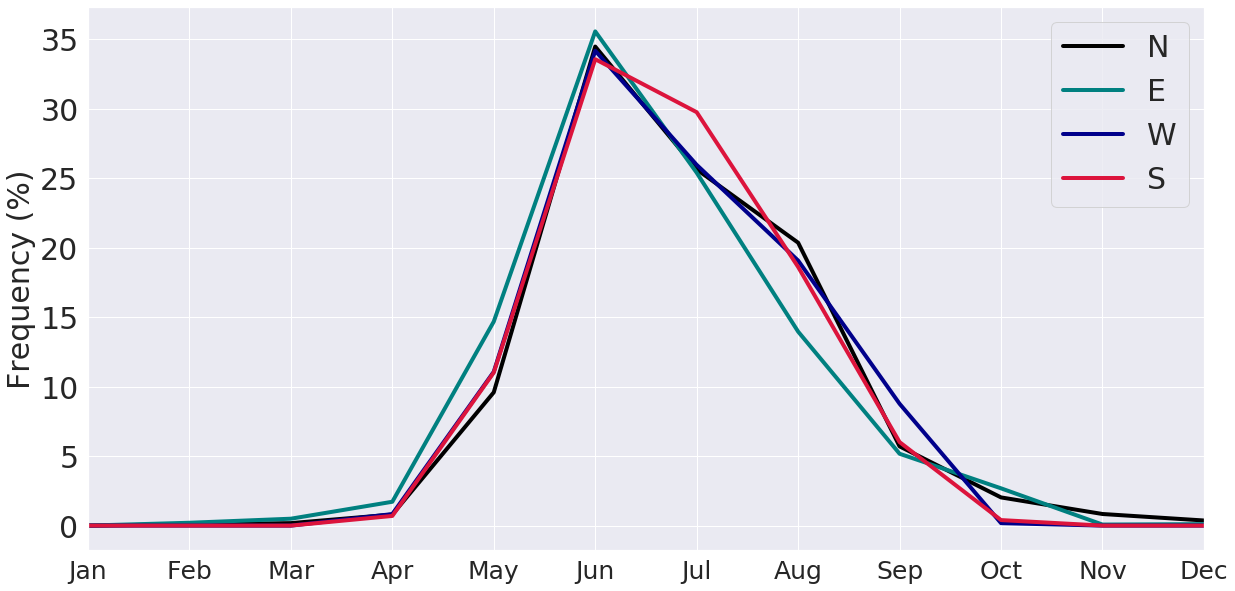

In [247]:
seasonal_precip = get_seasonal_cycle(tracksN)
seasonal_tbb_rain= get_seasonal_cycle(tracksE)
seasonal_tbb_cold= get_seasonal_cycle(tracksW)
seasonal_tbb= get_seasonal_cycle(tracksS)


import seaborn as sns 
sns.set()


plt.figure(figsize=(20,10))

plt.plot(seasonal_precip/np.nansum(seasonal_precip)*100, label = 'N', color= 'black', linewidth= 4.0)
plt.plot(seasonal_tbb_rain/ np.nansum(seasonal_tbb_rain)*100, label = 'E', color= 'teal', linestyle='-', linewidth= 4.0)
plt.plot(seasonal_tbb_cold/ np.nansum(seasonal_tbb_cold)*100, label = 'W', color= 'darkblue',  linewidth= 4.0)
plt.plot(seasonal_tbb/ np.nansum(seasonal_tbb)*100, label = 'S', color= 'crimson', linewidth= 4.0)


plt.legend(fontsize= 30)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'], fontsize = 25)
plt.yticks(np.linspace(0,35, 8), fontsize = 30 )
plt.xlim(0,11)
plt.ylabel('Frequency (%)', fontsize = 30)
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/seasonal_cycle_directions_tp.png')
plt.show()

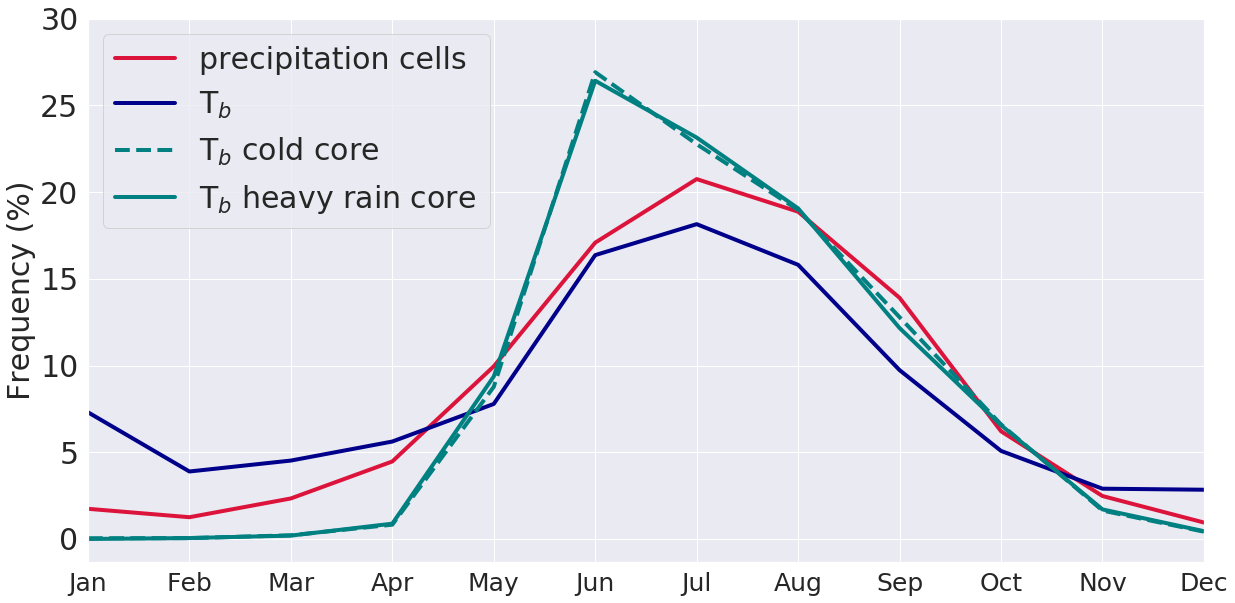

In [460]:
seasonal_precip = get_seasonal_cycle(preciptracks)
seasonal_tbb_rain= get_seasonal_cycle(tbbtracks)
seasonal_tbb_cold= get_seasonal_cycle(tbbcold)
seasonal_tbb= get_seasonal_cycle(tbb)


import seaborn as sns 
sns.set()


plt.figure(figsize=(20,10))

plt.plot(seasonal_precip/np.nansum(seasonal_precip)*100, label = 'precipitation cells', color= 'crimson', linewidth= 4.0)
plt.plot(seasonal_tbb/ np.nansum(seasonal_tbb)*100, label = 'T$_b$', color= 'darkblue', linewidth= 4.0)
plt.plot(seasonal_tbb_cold/ np.nansum(seasonal_tbb_cold)*100, label = 'T$_b$ cold core', color= 'teal', linestyle='--', linewidth= 4.0)

plt.plot(seasonal_tbb_rain/ np.nansum(seasonal_tbb_rain)*100, label = 'T$_b$ heavy rain core ', color= 'teal', linewidth= 4.0)

plt.legend(fontsize= 30)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'], fontsize = 25)
plt.yticks(np.linspace(0,30, 7), fontsize = 30 )
plt.xlim(0,11)
plt.ylabel('Frequency (%)', fontsize = 30)
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/seasonal_cycle_trackingmethods_domain.png')
plt.show()

##  lifetime histogram 

In [371]:
def get_lifetime(tracks):
    lt= []
    for y in np.arange(2000,2020):
        ytracks = tracks[tracks.timestr.dt.year== y]
        for cell in np.unique(ytracks.cell.values):
            hours= ytracks[ytracks.cell== cell].shape[0] * 0.5
            lt.append(hours)
    lt = np.array(lt)
    lt= np.histogram(lt, bins= np.arange(6,49)[::2]) 
    print('lifetime histo calculated.')
    return lt

## remove all short-lived precipitation cells to compare lifetime histograms

In [386]:
def get_lifetime(tracks):
    lt= []
    for y in np.arange(2000,2020):
        ytracks = tracks[tracks.timestr.dt.year== y]
        for cell in np.unique(ytracks.cell.values):
            hours= ytracks[ytracks.cell== cell].shape[0] * 0.5
            if hours >=6:
                lt.append(hours)
    lt = np.array(lt)
    lt= np.histogram(lt, bins=np.arange(6,49)[::2] ) 
    print('lifetime histo calculated.')
    return lt

lt_precip= get_lifetime(preciptracks)

lifetime histo calculated.


In [385]:
#lt_precip= get_lifetime(preciptracks)
lt_tbb_rain= get_lifetime(tbbtracks)
lt_tbb_cold= get_lifetime(tbbcold)
lt_tbb= get_lifetime(tbb)

lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.


In [615]:
lt_tbb_rain= get_lifetime(tracks_N)
lt_tbb_cold= get_lifetime(tracks_E)
lt_tbb= get_lifetime(tracks_n)
lt_precip= get_lifetime(tracks_e)

lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.
lifetime histo calculated.


## Check out lifetime diagram for different time periods! 

2010 - 2018 gives a different lifetime distribution -> evidence strengthening of monsoon ?

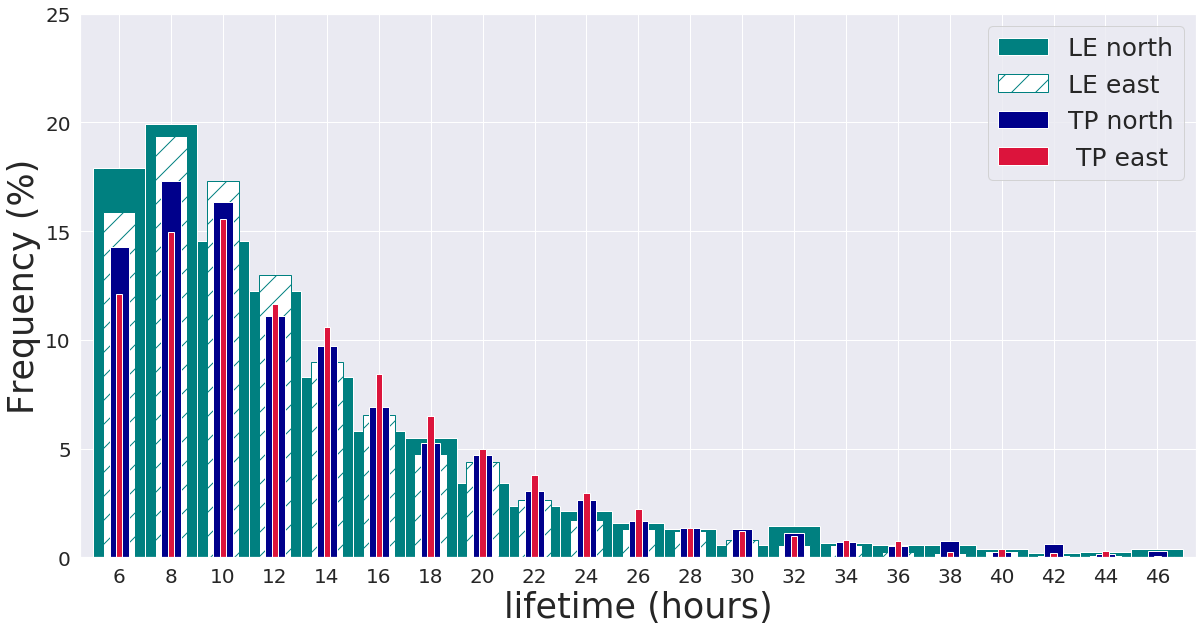

In [623]:
bins = lt_precip[1]
import matplotlib.pyplot as plt

import seaborn as sns 
sns.set()

plt.figure(figsize=(20,10))

plt.bar(bins[:-1] , lt_tbb_rain[0]/ np.nansum(lt_tbb_rain[0])*100, label= 'LE north', width=0.8*2.5,color= 'teal')
plt.bar(bins[:-1] , lt_tbb_cold[0]/ np.nansum(lt_tbb_cold[0])*100, label = 'LE east', width = 0.5*2.5,hatch= '/', edgecolor= 'teal', color= 'white')
plt.bar(bins[:-1] , lt_tbb[0]/ np.nansum(lt_tbb[0])*100, label= 'TP north', width= 0.3*2.5, color= 'darkblue')
plt.bar(bins[:-1] , lt_precip[0]/ np.nansum(lt_precip[0])*100, label=' TP east', width = 0.1*2.5, color= 'crimson')

plt.legend(fontsize= 25)

plt.xticks(bins[:], fontsize = 20)
plt.yticks(np.linspace(0,25,6), fontsize = 20)
plt.xlim(4.5, 47.5)
plt.xlabel('lifetime (hours)', fontsize= 35)
plt.ylabel('Frequency (%)', fontsize= 35)

plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/lifetime_mcstypes_2000-2019.png')
plt.show()

## Area distribution 

In [633]:
def get_area(tracks):
    a= []
    for cell in np.unique(tracks.cell.values):
        area= np.nanmean(tracks[tracks.cell== cell].ncells.values)
        a.append(area)
    a = np.array(a)
    a = np.histogram(a, bins=(50, 100,150, 200, 300, 400, 500, 750, 1000, 1250, 1500 , 1750,2000, 2500, 3000, 3500, 4000, 4500, 5000))
    print('area histo calculated.')
    return a

In [406]:
a_precip= get_area(preciptracks)
a_tbb_rain= get_area(tbbtracks)
a_tbb_cold= get_area(tbbcold)
a_tbb= get_area(tbb)

area histo calculated.
area histo calculated.
area histo calculated.
area histo calculated.


In [674]:
def get_area(tracks):
    a= []
    for cell in np.unique(tracks.cell.values):
        area= np.mean(tracks[tracks.cell== cell].ncells.values)
        a.append(area)
    a = np.array(a)
    a = np.histogram(a, bins=(250,500, 750, 1000, 1250, 1500 ,1750, 2000, 2250,2500,2750, 3000, 3250,3500, 4000))
    print('area histo calculated.')
    return a

In [675]:
a_precip= get_area(tracks_N)
a_tbb_rain= get_area(tracks_E)
a_tbb_cold= get_area(tracks_n)
a_tbb= get_area(tracks_e)

area histo calculated.
area histo calculated.
area histo calculated.
area histo calculated.


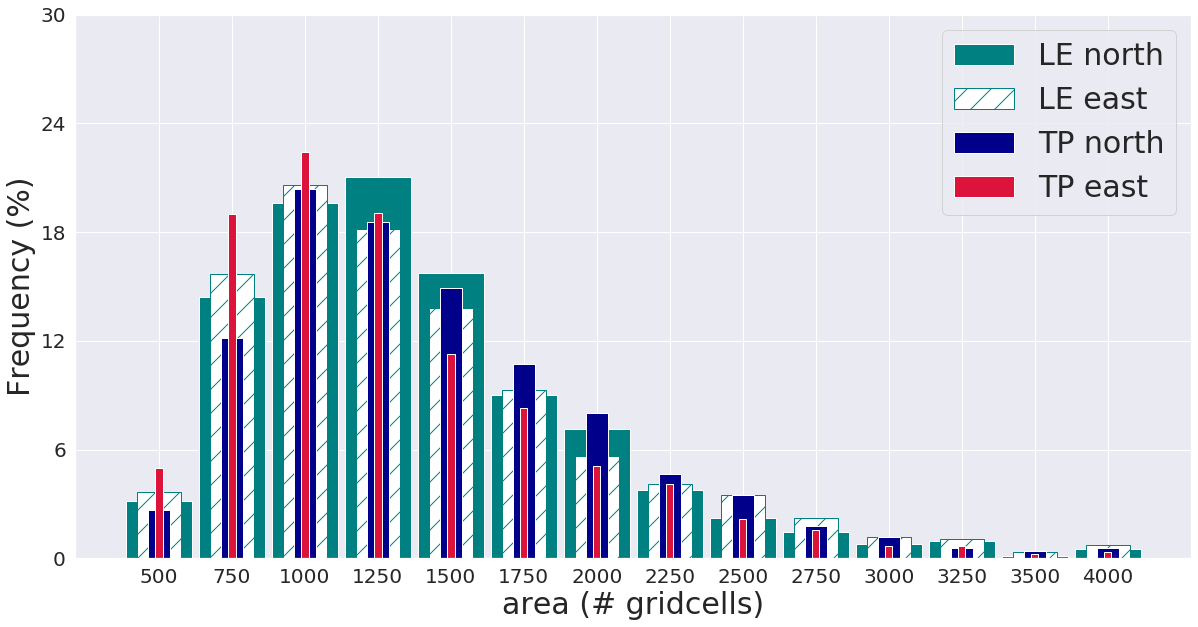

In [678]:
bins = a_tbb[1]
plt.figure(figsize=(20,10))

ticks =np.arange(14)


plt.bar(ticks, a_tbb_rain[0]/ np.nansum(a_tbb_rain[0]) * 100 , label= 'LE north', width=0.9,color= 'teal')
plt.bar(ticks , a_tbb_cold[0]/ np.nansum(a_tbb_cold[0]) * 100 , label = 'LE east', width = 0.6  ,hatch= '/', edgecolor= 'teal', color= 'white')
plt.bar(ticks , a_tbb[0]/ np.nansum(a_tbb[0]) * 100 , label= 'TP north', width= 0.3 , color= 'darkblue')
plt.bar(ticks , a_precip[0]/ np.nansum(a_precip[0]) * 100 , label='TP east', width = 0.1, color= 'crimson')

plt.legend(fontsize= 30)

plt.xticks(ticks , bins[1:], fontsize = 20)
plt.yticks(np.linspace(0,30,6), fontsize= 20 )

plt.xlabel('area (# gridcells)', fontsize= 30)
plt.ylabel('Frequency (%)', fontsize= 30)
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/area_mcsclasses.png')
plt.show()

## Propagation speed 

In [595]:
# calculate propagation speed (tobac can be used)
import tobac
tracks= tobac.calculate_velocity(tbb, method_distance=None)


## Propagation speed histogram 

In [750]:
def get_v(tracks):
    v= []
    for cell in np.unique(tracks.cell.values):
        ps = np.nanmean(tracks[tracks.cell== cell].v.values)
        v.append(ps)
    v = np.array(v)
    v = np.histogram(v, bins=np.arange(6,31)[::2]) 
    print('propagation speed histo calculated.')
    return v

In [751]:
N= get_v(tracks_N)
E= get_v(tracks_E)
n= get_v(tracks_n)
e= get_v(tracks_e)

propagation speed histo calculated.
propagation speed histo calculated.
propagation speed histo calculated.
propagation speed histo calculated.


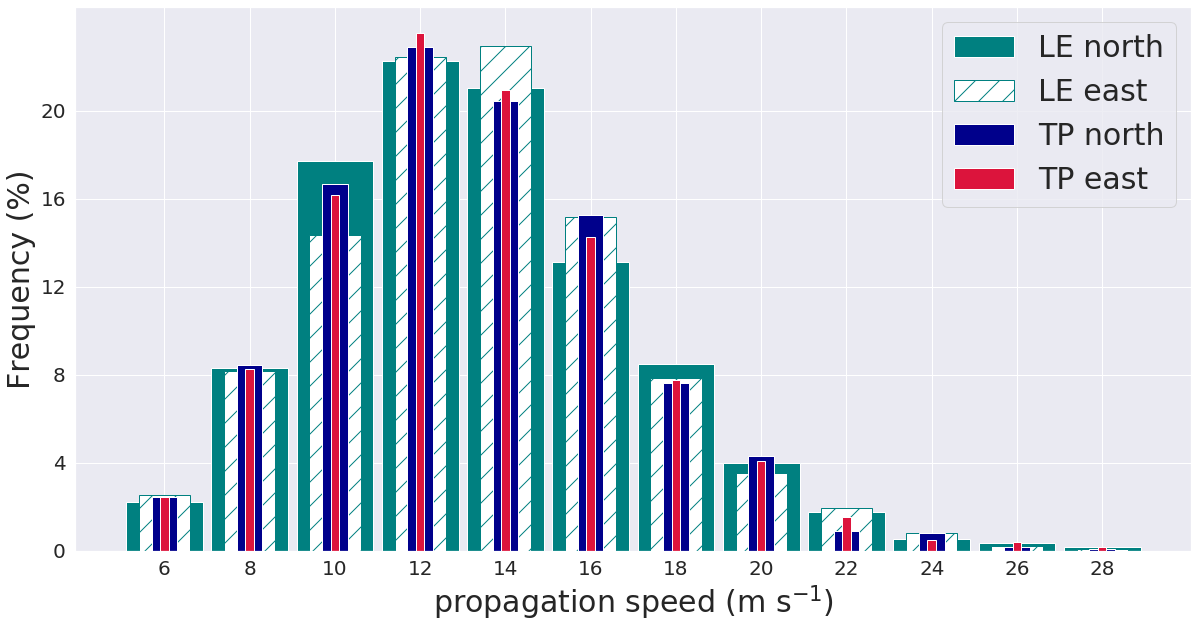

In [756]:
# plot 

bins = N[1]
plt.figure(figsize=(20,10))

ticks =np.arange(bins.shape[0]- 1)

plt.bar(ticks, N[0]/ np.nansum(N[0]) * 100 , label= 'LE north', width=0.9,color= 'teal')
plt.bar(ticks , E[0]/ np.nansum(E[0]) * 100 , label = 'LE east', width = 0.6  ,hatch= '/', edgecolor= 'teal', color= 'white')
plt.bar(ticks , n[0]/ np.nansum(n[0]) * 100 , label= 'TP north', width= 0.3 , color= 'darkblue')
plt.bar(ticks , e[0]/ np.nansum(e[0]) * 100 , label='TP east', width = 0.1, color= 'crimson')

plt.legend(fontsize= 30)

plt.xticks(ticks , bins[::], fontsize = 20)
plt.yticks(np.linspace(0,20,6), fontsize= 20 )

plt.xlabel('propagation speed (m s$^{-1}$)', fontsize= 30)
plt.ylabel('Frequency (%)', fontsize= 30)
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/propagationspeed_mcsclasses.png')
plt.show()




# Classification of convective cells 

1. TP, east 
2. TP, TP north 
3. surrounding, east
4. surrounding, north 





In [233]:
# divide into north-moving, east-moving and other 

def propagation_dir(tracks):
    pd.options.mode.chained_assignment = None 
    
    tracks['dir'] = 0 
    for c in np.unique(tracks.cell.values):
        cell= tracks[tracks.cell == c]

        west_east= cell.longitude.values[-1] - cell.longitude.values[0]
        north_south = cell.latitude.values[-1] - cell.latitude.values[0]

        if north_south > west_east:
            if np.nanmean(cell.latitude.values[0:2]) < np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'N'
            elif np.nanmean(cell.latitude.values[0:2]) > np.nanmean(cell.latitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'S'
                
        elif north_south < west_east:
            if np.nanmean(cell.longitude.values[0:2]) < np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'E'
            elif np.nanmean(cell.longitude.values[0:2]) > np.nanmean(cell.longitude.values[-3:-1]):
                tracks['dir'][tracks.cell == c] =  'W'
    return tracks 

In [234]:
#  separate tracks based on propagation direction, thresholds for intensity, and TP domain vs. surrounding 
track_sr= propagation_dir(surrounding_tracks)
track_tp = propagation_dir(tp_tracks)

tbb = tp_tracks
print(tbb[tbb.dir=='N'].shape,tbb[tbb.dir=='E'].shape, tbb[tbb.dir=='W'].shape, tbb[tbb.dir=='S'].shape)
tbb = surrounding_tracks
print(tbb[tbb.dir=='N'].shape,tbb[tbb.dir=='E'].shape, tbb[tbb.dir=='W'].shape, tbb[tbb.dir=='S'].shape)

(40655, 20) (58208, 20) (15338, 20) (27789, 20)
(56969, 20) (46853, 20) (13656, 20) (35002, 20)


## select all northern and eastern moving cells 

In [718]:
tracks_e= pd.DataFrame(columns = track_tp.columns)
tracks_n= pd.DataFrame(columns = track_tp.columns)

for y in np.unique(track_tp.timestr.dt.year):
    subset = track_tp[track_tp.timestr.dt.year == y]
    for i in np.unique(subset.cell.values):
        cell = subset[subset.cell == i]
        if cell.dir.values[0] == 'E':
            tracks_e= tracks_e.append(cell)
        if cell.dir.values[0] == 'N':
            tracks_n= tracks_n.append(cell)

In [719]:
tracks_E= pd.DataFrame(columns = track_sr.columns)
tracks_N= pd.DataFrame(columns = track_sr.columns)

for y in np.unique(track_sr.timestr.dt.year):
    subset = track_sr[track_sr.timestr.dt.year == y]
    for i in np.unique(subset.cell.values):
        cell = subset[subset.cell == i]
        if cell.dir.values[0] == 'E':
            tracks_E= tracks_E.append(cell)
        if cell.dir.values[0] == 'N':
            tracks_N= tracks_N.append(cell)

## save all four types

In [721]:
tracks_e.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_e.h5','table')
tracks_n.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_n.h5','table')

tracks_E.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_e.h5','table')
tracks_N.to_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_n.h5','table')


In [102]:
tracks_e = pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_e.h5','table')
tracks_n= pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_n.h5','table')

tracks_E= pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_e.h5','table')
tracks_N =pd.read_hdf('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_n.h5','table')


In [110]:
print(tracks_e.shape)
print(tracks_n.shape)
print(tracks_E.shape)
print(tracks_N.shape)


(58208, 20)
(40655, 20)
(46853, 20)
(56969, 20)


## Density plots 

- maybe just indicate locations with dot in for different colors 
- different sizes for initiation and dissipation 

In [757]:
# density plot of spatial distribution 
# density intitiation vs. dissipation 

In [114]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [133]:
def track_density(tracks, elevations):
    # empty mask for TP region 
    track_count = np.zeros((600,350))
    for idx in np.arange(tracks.shape[0]):
        # get coords 
        lat = tracks.latitude.values[idx]
        lon = tracks.longitude.values[idx]
        # get closest coordinate 
        lo = find_nearest(elevations.lon.values, lon)
        la = find_nearest(elevations.lat.values, lat)
        # get corresponding indices 
        x = np.where(elevations.lon == lo)[0]
        y = np.where(elevations.lat == la)[0]
        # count at coordinate location 
        track_count[x,y] += 1
    return track_count
        

In [134]:
track_count_e  = track_density(tracks_e, elevations)
track_count_n  = track_density(tracks_n, elevations)
track_count_E  = track_density(tracks_E, elevations)
track_count_N  = track_density(tracks_N, elevations)

In [10]:
track_count_e = np.fromfile('track_count_e.npy')
track_count_n = np.fromfile('track_count_n.npy')
track_count_E = np.fromfile('track_count_E.npy')
track_count_N= np.fromfile('track_count_N.npy')

In [144]:
## Import elevation file for 3000 m boundary 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
lon = elevations.lon.values
lat= elevations.lat.values

In [150]:
track_count = np.resize(track_count_N, (600,350))

## select coordinates for initiation and dissipation 

In [196]:
def get_init(tracks):
    init_lats= []
    init_lons= []
    diss_lats= []
    diss_lons= []
    for cell in np.unique(tracks.cell.values):
        subset= tracks[tracks.cell == cell]
        init_lats.append(subset.latitude.values[0])
        init_lons.append(subset.longitude.values[0])
        diss_lats.append(subset.latitude.values[-1])
        diss_lons.append(subset.longitude.values[-1])
    return np.array(init_lats), np.array(init_lons), np.array(diss_lats), np.array(diss_lons)

In [197]:
init_lats_e, init_lons_e, diss_lats_e, diss_lons_e = get_init(tracks_e)
init_lats_n, init_lons_n , diss_lats_n, diss_lons_n = get_init(tracks_n)

In [216]:
init_lats_E, init_lons_E, diss_lats_E, diss_lons_E = get_init(tracks_E)
init_lats_N, init_lons_N , diss_lats_N, diss_lons_N = get_init(tracks_N)

In [266]:
tpcells

74

In [261]:
tpcells= 0 
for cell in np.unique(tp_tracks.cell.values):
    subset = tp_tracks[tp_tracks.cell == cell]
    if 0 not in subset.tp_flag.values:
        tpcells+= 1 

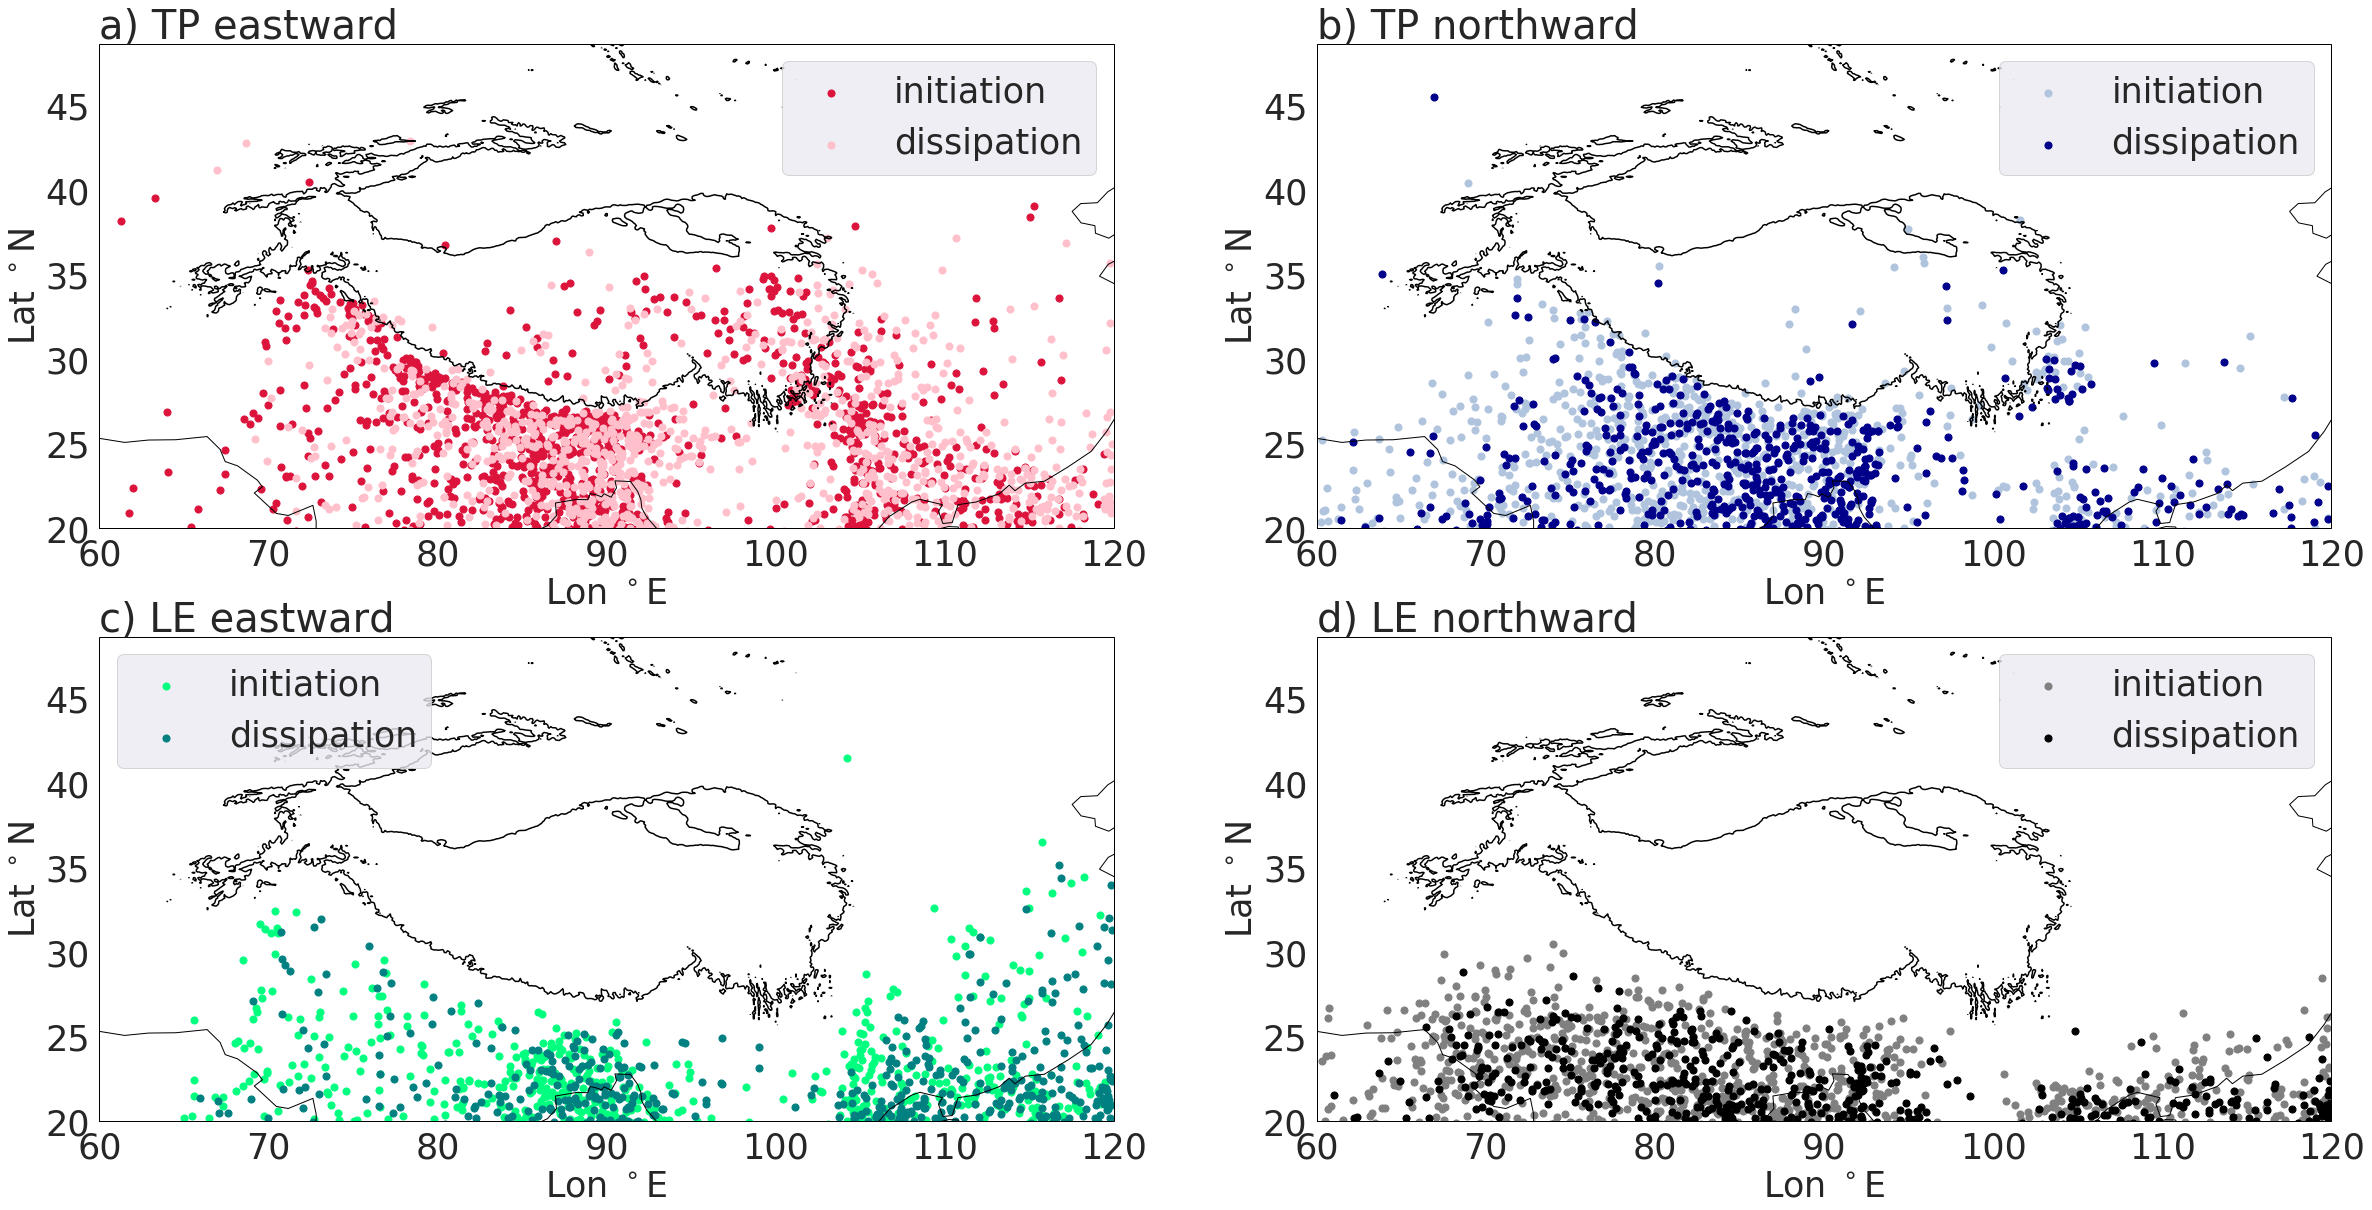

In [345]:
## track density plot 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

plt.figure(figsize=(40,20))
xlabels=[60,70,80,90,100,110,120]
ylabels= [20,30,40]
# markersize 
s = 50



# Tracks TP eastwards 
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(elevations.lon.values),np.nanmax(elevations.lon.values),20,45])
ax1.scatter(init_lons_e, init_lats_e,  color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'initiation')
ax1.scatter(diss_lons_e, diss_lats_e,  color='pink',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'dissipation')
ax1.coastlines()
# 3000 m boundary 
ax1.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')
# axis labels 
ax1.legend(fontsize= 35)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=35)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=35)
ax1.set_title('a) TP eastward', fontsize = 40, loc ='left')


# Tracks TP northward 
ax2 = plt.subplot(2, 2, 2 , projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(elevations.lon.values),np.nanmax(elevations.lon.values),20,45])
ax2.scatter(diss_lons_n, diss_lats_n, color='lightsteelblue',marker='o', s =s, transform=ccrs.PlateCarree(),label = 'initiation')
ax2.scatter(init_lons_n, init_lats_n, color='darkblue',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'dissipation')
ax2.coastlines()
# 3000 m boundary 
ax2.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')
# axis labels 
ax2.legend(fontsize= 35)
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=35)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=35)
ax2.set_title('b) TP northward', fontsize = 40, loc ='left')

# Tracks eastwards 
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(elevations.lon.values),np.nanmax(elevations.lon.values),20,45])
ax3.scatter(init_lons_E, init_lats_E,  color='springgreen',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'initiation')
ax3.scatter(diss_lons_E, diss_lats_E,  color='teal',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'dissipation')
ax3.coastlines()
# 3000 m boundary 
ax3.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')
# axis labels 
ax3.legend(fontsize= 35)
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=35)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=35)
ax3.set_title('c) LE eastward', fontsize = 40, loc ='left')

# Tracks  northward 
ax4 = plt.subplot(2, 2, 4 , projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(elevations.lon.values),np.nanmax(elevations.lon.values),20,45])
ax4.scatter(diss_lons_N, diss_lats_N, color='grey',marker='o', s = s, transform=ccrs.PlateCarree(),label = 'initiation')
ax4.scatter(init_lons_N, init_lats_N, color='black',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'dissipation')
ax4.coastlines()
# 3000 m boundary 
ax4.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')
# axis labels 
ax4.legend(fontsize= 35)
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=35)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=35)
ax4.set_title('d) LE northward', fontsize = 40, loc ='left')


plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 
plt.savefig('track_densities.png')
plt.show()


## Contribution to total precipitation 

1. Seasonal curve with contribution to total precipitation, TP vs outside of TP, fraction of convective precip

! fix months for which timestep shape is not equal 
! combine with precip from GPM: fraction of total precip 
 


In [54]:
# get total precipitation from GPM within TP 3000 m boundary 

tp_precip = '/media/juli/Data/projects/mcs_tracking/CTT/analysis/'



In [42]:
tp_tracks = tbbtracks[tbbtracks.tp_flag > 0]

In [361]:
1465/124

11.814516129032258

In [377]:
# calculate precip amount per month 

tbbtracks['month']= tbbtracks.timestr.dt.month

seasonal_conv=[]
seasonal_tot=[]

for m in np.arange(1,13):
    p = tbbtracks[tbbtracks.month== m]
    total_precip= np.nansum(p.total_precip.values)
    convective_precip= np.nansum(p.convective_precip.values)
    seasonal_conv.append(convective_precip)
    seasonal_tot.append(total_precip)


In [379]:
tbbtracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells,cell,time_cell,rain_flag,tp_flag,total_precip,convective_precip,v,month
23,1,4,4.177896,481.202941,106,205,24,2000-06-01 00:30:00,2000-06-01 00:30:00,15.367790,108.170295,226,16.0,0 days 00:00:00,124,0,1465.601685,1249.900513,2.380881,6
36,2,5,4.401369,480.877803,124,205,37,2000-06-01 01:00:00,2000-06-01 01:00:00,15.390137,108.137782,254,16.0,0 days 00:30:00,141,0,1403.481323,1043.959351,18.217286,6
48,3,3,4.555832,477.826623,125,200,49,2000-06-01 01:30:00,2000-06-01 01:30:00,15.405583,107.832661,243,16.0,0 days 01:00:00,151,0,1456.031860,1139.050537,10.297663,6
60,4,3,4.476111,476.101417,149,200,61,2000-06-01 02:00:00,2000-06-01 02:00:00,15.397611,107.660143,269,16.0,0 days 01:30:00,20,0,225.172913,114.171936,13.652449,6
72,5,3,5.351239,478.204086,117,200,73,2000-06-01 02:30:00,2000-06-01 02:30:00,15.485124,107.870407,302,16.0,0 days 02:00:00,271,0,1883.732910,1399.723145,20.983033,6
84,6,2,4.158765,474.908831,143,200,85,2000-06-01 03:00:00,2000-06-01 03:00:00,15.365877,107.540886,323,16.0,0 days 02:30:00,297,0,2313.811035,1500.786377,55.268123,6
93,7,3,12.877642,472.869949,335,205,94,2000-06-01 03:30:00,2000-06-01 03:30:00,16.237764,107.336994,895,16.0,0 days 03:00:00,20,0,338.104156,96.651085,7.835213,6
101,8,3,13.729361,471.892805,396,205,102,2000-06-01 04:00:00,2000-06-01 04:00:00,16.322936,107.239281,1001,16.0,0 days 03:30:00,240,0,2090.262695,1302.741211,38.438369,6
110,9,3,19.775200,470.387585,330,205,111,2000-06-01 04:30:00,2000-06-01 04:30:00,16.927521,107.088761,1059,16.0,0 days 04:00:00,767,0,6313.696777,4734.914062,22.861222,6
120,10,3,22.992374,468.482774,277,205,121,2000-06-01 05:00:00,2000-06-01 05:00:00,17.249237,106.898275,1200,16.0,0 days 04:30:00,283,0,2453.750488,1067.850464,12.174192,6


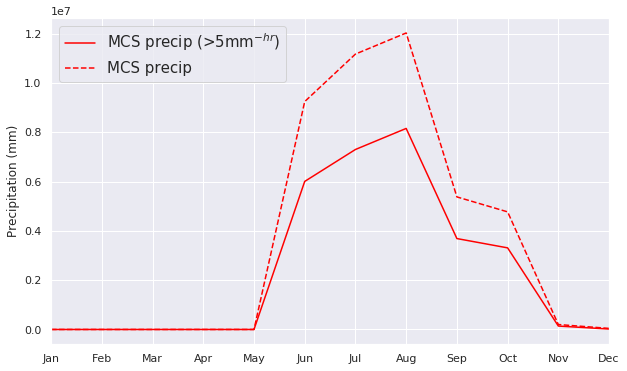

In [378]:
import seaborn as sns 
sns.set()

plt.figure(figsize=(10,6))
plt.plot(seasonal_conv, label = 'MCS precip (>5mm$^{-hr}$)', color= 'red')
plt.plot(seasonal_tot, label = 'MCS precip', color= 'red', linestyle='--')

plt.legend(fontsize= 15)

plt.xticks(np.arange(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'])
plt.xlim(0,11)
plt.ylabel('Precipitation (mm)')



plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/contribution_to_precip.png')
plt.show()


## Convective structure of precipitation features 

In [651]:
def convection(tracks):
    thresholds= np.unique(tracks.threshold_value.values)
    fractions= np.zeros((9,))
    areas= np.zeros((9,))
    for i, t in enumerate(thresholds):
        subset = tracks[tracks.threshold_value== t ]
        sub= subset[subset.rain_flag > 0 ]
        conv_fr= sub.convective_precip.values / sub.rain_flag.values
        conv_area =  sub.rain_flag.values
        #/ subset.total_precip.values * 100 
        fractions[i] = np.mean(conv_fr)
        areas[i] = np.mean(conv_area)
    return thresholds, np.array(fractions), np.array(areas)


In [652]:
thresholds, fractions_e, areas_e = convection(tracks_e)
thresholds, fractions_n, areas_n = convection(tracks_n)
thresholds, fractions_E, areas_E = convection(tracks_E)
thresholds, fractions_N, areas_N = convection(tracks_N)
thresholds, fractions, areas = convection(tbbtracks)

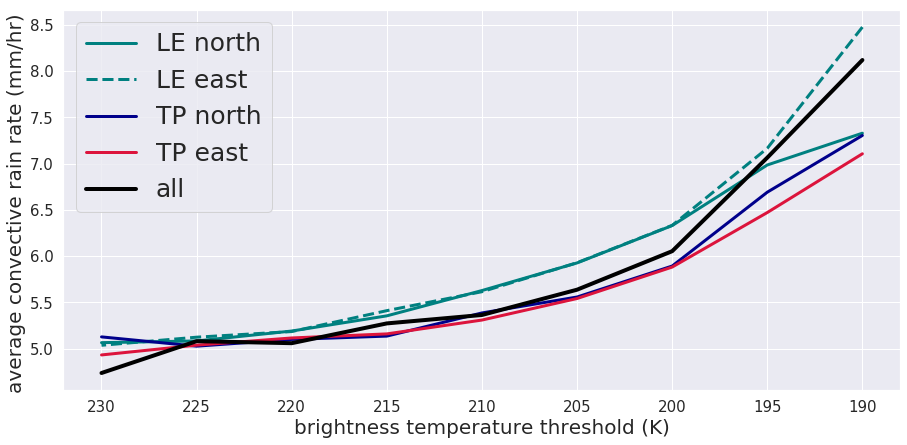

In [656]:
plt.figure(figsize= (15,7))

plt.plot(np.flip(thresholds, axis = 0 ), fractions_N, c= 'teal', label= 'LE north', linewidth =3.0)
plt.plot(np.flip(thresholds, axis = 0 ), fractions_E, c= 'teal', label= 'LE east', linewidth= 3.0, linestyle = '--')
plt.plot(np.flip(thresholds, axis = 0 ), fractions_n, c= 'darkblue', label = 'TP north', linewidth= 3.0)
plt.plot(np.flip(thresholds, axis = 0 ), fractions_e, c= 'crimson', label = 'TP east', linewidth= 3.0)
plt.plot(np.flip(thresholds, axis = 0 ), fractions, c= 'black', label= 'all', linewidth= 4.0)

#plt.plot(np.flip(thresholds, axis = 0 ), areas_N, c= 'teal', label= 'LE north', linewidth =3.0)
#plt.plot(np.flip(thresholds, axis = 0 ), areas_E, c= 'teal', label= 'LE east', linewidth= 3.0, linestyle = '--')
#plt.plot(np.flip(thresholds, axis = 0 ), areas_n, c= 'darkblue', label = 'TP north', linewidth= 3.0)
#plt.plot(np.flip(thresholds, axis = 0 ), areas_e, c= 'crimson', label = 'TP east', linewidth= 3.0)
#plt.plot(np.flip(thresholds, axis = 0 ), areas, c= 'black', label= 'all', linewidth= 4.0)


plt.legend(fontsize= 25 )
plt.xticks(thresholds, np.linspace(230,190, 9).astype(int))
plt.xlabel('brightness temperature threshold (K)', fontsize = 20)
plt.ylabel('average convective rain rate (mm/hr) ', fontsize= 20)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 


plt.savefig('convective_precip_strentgh_ctt.png')

In [592]:
# convective areas 

def get_area(tracks):
    a= []
    for cell in np.unique(tracks.cell.values):
        area= np.mean(tracks[tracks.cell== cell].rain_flag.values)
        a.append(area)
    areas = np.array(a)
    histo = np.histogram(areas, bins=(100, 200, 300, 400, 500, 600, 700, 800, 1000, 1100, 1200, 1300,1400, 1500, 1600 ))
    print('area histo calculated.')
    return histo


In [593]:
a_precip= get_area(tracks_N)
a_tbb_rain= get_area(tracks_E)
a_tbb_cold= get_area(tracks_n)
a_tbb= get_area(tracks_e)

area histo calculated.
area histo calculated.
area histo calculated.
area histo calculated.


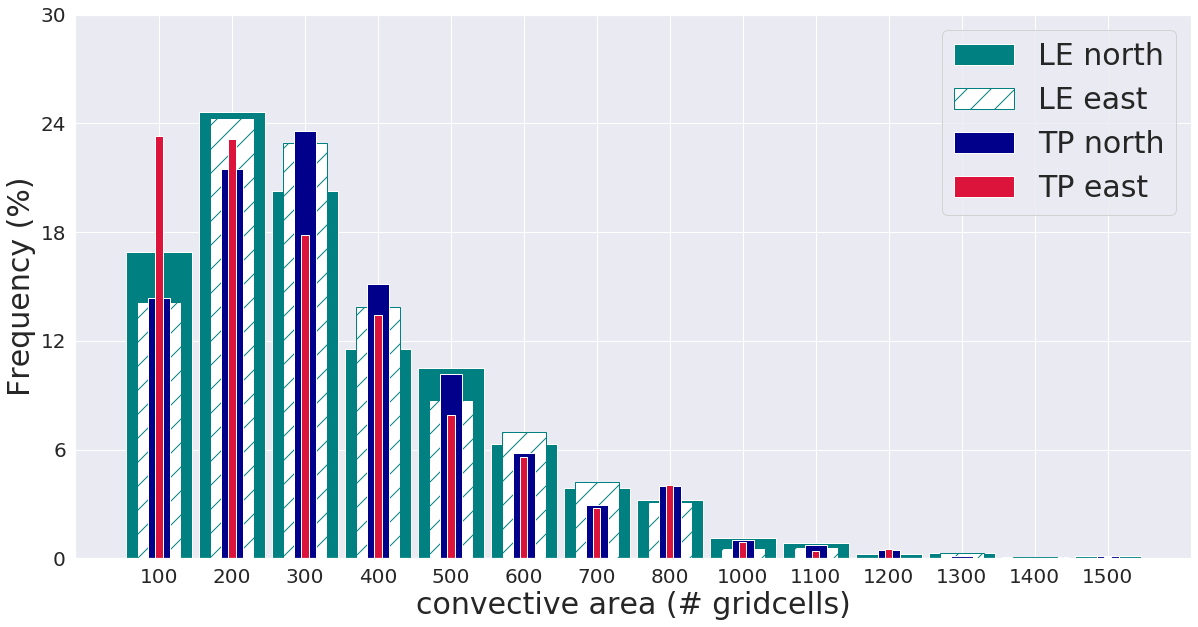

In [594]:
bins = a_tbb[1]
plt.figure(figsize=(20,10))

ticks =np.arange(bins.shape[0]-1 )


plt.bar(ticks, a_tbb_rain[0]/ np.nansum(a_tbb_rain[0]) * 100 , label= 'LE north', width=0.9,color= 'teal')
plt.bar(ticks , a_tbb_cold[0]/ np.nansum(a_tbb_cold[0]) * 100 , label = 'LE east', width = 0.6  ,hatch= '/', edgecolor= 'teal', color= 'white')
plt.bar(ticks , a_tbb[0]/ np.nansum(a_tbb[0]) * 100 , label= 'TP north', width= 0.3 , color= 'darkblue')
plt.bar(ticks , a_precip[0]/ np.nansum(a_precip[0]) * 100 , label='TP east', width = 0.1, color= 'crimson')

plt.legend(fontsize= 30)

plt.xticks(ticks , bins[:], fontsize = 20)
plt.yticks(np.linspace(0,30,6), fontsize= 20 )

plt.xlabel('convective area (# gridcells)', fontsize= 30)
plt.ylabel('Frequency (%)', fontsize= 30)
plt.savefig('/media/juli/Data/projects/mcs_tracking/CTT/analysis/convectivearea_mcsclasses.png')
plt.show()

In [610]:
# examples for extreme convective core 

subset= tracks_e[tracks_e.tp_flag == tracks_e.rain_flag]
tp = subset[subset.convective_precip == np.max(subset.convective_precip.values)]
tp.idx

68293    667
Name: idx, dtype: object

In [596]:
tracks_N[tracks_N.convective_precip == np.max(tracks_N.convective_precip.values)]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,...,ncells,cell,time_cell,rain_flag,tp_flag,total_precip,convective_precip,v,dir,hour
69631,9529,746,64.034176,283.882518,196,210,12633,2008-06-16 13:00:00,2008-06-16 13:00:00,21.353418,...,389,11287.0,0 days,2005,0,28547.222656,26896.439453,12.320648,N,13


In [562]:
# convective vs stratiform 
t = np.sum(tracks_e.total_precip.values)
s= np.sum(tracks_e.total_precip.values - tracks_e.convective_precip.values)
c= np.sum(tracks_e.convective_precip.values)

print(c/t, s/t) 

0.6365978323140236 0.36340216768597644


## cells with highest environmental impact

In [375]:
def environmental_impact(tracks):
    impact_factor = []
    for cell in np.unique(tracks.cell.values):
        subset= tracks[tracks.cell == cell]
        en_impact =  np.nansum(subset.total_precip.values / subset.v.values )
        impact_factor.append(en_impact)
            
    impact_factor.sort()
    return np.array(impact_factor)
    

In [376]:
impact_e = environmental_impact(tracks_e)
impact_n = environmental_impact(tracks_n)
impact_E = environmental_impact(tracks_E)
impact_N = environmental_impact(tracks_N)

In [358]:
print(impact_e[-10:-1])
print(impact_n[-10:-1])
print(impact_E[-10:-1])
print(impact_N[-10:-1])

[ 98510.28757614  98665.44840334 101905.91409231 104049.20368877
 104249.52632196 104636.15024602 107091.6063886  109677.4665541
 126467.43400518]
[105110.36190786 105719.62977356 106540.24883844 107695.92094101
 112405.15932251 112440.00623168 134751.99994007 135141.90511469
 139674.42624532]
[ 85756.11606605  90717.58186599 105770.07964547 111663.42982927
 112760.57678488 115928.35351075 119218.83348115 124368.59922551
 130630.63398264]
[ 98766.7166233   98989.04014742 110979.49187887 116253.84194815
 117263.33338113 122299.44688586 126316.88513563 145901.89673799
 354918.13710048]


## Trends of convective cells in TP region, any change in the past two decades? 

- change in total number 
- change of in associated rainfall 